# EOSC 582 Final Project

The effictivness of passive microwave remote sensing in sea-ice classification

To see how clustering techniques like K-means can contribute to sea-ice classification in different regimes

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca'

In [2]:
#from IPython.core.display import HTML
#HTML(open("../custom.css", "r").read()) <---- Not proper disigned for Jupyter

# Content
1. [**Shared functions**](#Shared-functions)
1. [**Data and Methods**](#Read-data)
  2. [Data](#Data)
  2. [Methods](#Methods)
1. [**Sea-ice classification**](#Sea-ice-classification)
  2. [37 GHz PR v.s. 18.7 GHz PR](#37-GHz-PR-v.s.-18.7-GHz-PR)
  2. [37 GHz, V-pol. $\mathsf{T_B}$ v.s. 18.7 GHz, V-pol. $\mathsf{T_B}$](#37-GHz,-V-pol.-$\mathsf{T_B}$-v.s.-18.7-GHz,-V-pol.-$\mathsf{T_B}$)
1. [**Summary**](#Summary)
1. [**Reference**](#Reference)

In [3]:
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [4]:
from sklearn.cluster import KMeans # KMeans
#from sklearn.metrics.pairwise import pairwise_distances_argmin
#from sklearn.mixture import GMM # Gaussian mixture
#from matplotlib.colors import LogNorm

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Shared functions

In [6]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

In [7]:
def po_ratio(vpol, hpol):
    '''
    polarization ratio
    '''
    return (vpol-hpol)/(vpol+hpol)
def grad_ratio(vpol1, vpol2):
    '''
    gradient ratio (not used)
    '''
    return (vpol2-vpol1)/(vpol2+vpol1)

In [8]:
def map_Arctic(ax):
    '''
    map routine
    '''
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    # parallels & meridians
    parallels=np.arange(-90, 90, 15); meridians=np.arange(0, 360, 60)
    proj.drawparallels(parallels, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawmeridians(meridians, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    # coastline, maskland
    proj.drawcoastlines(linewidth=1.5, linestyle='-', color='k', zorder=3)
    #proj.drawlsmask(land_color=[0.5, 0.5, 0.5], ocean_color='None', lsmask=None, zorder=2)
    return proj

In [9]:
def hist2dxy(hist_x, hist_y, Xnum, Ynum, clevs, CMap=plt.cm.gist_ncar_r):
    '''
    Comprehensive 2-D histogram
    '''
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    Xlim=[np.nanmin(hist_x), np.nanmax(hist_x)]
    Xbins=np.linspace(Xlim[0], Xlim[1], Xnum, dtype=np.float)
    Ylim=[np.nanmin(hist_y), np.nanmax(hist_y)]
    Ybins=np.linspace(Ylim[0], Ylim[1], Ynum, dtype=np.float)
    H, y_edges, x_edges = np.histogram2d(hist_y, hist_x, bins=(Ybins, Xbins))
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    # set axis
    left=0.1; width = 0.8; bottom=0.1; height = 0.65
    gap=0.02; hist_len=0.2; cbar_len=0.12
    # three boxes
    rect_main  = [left+hist_len+gap, bottom, width, height]
    rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
    rect_histy = [left, bottom, hist_len, height]
    # x, y limits
    xlim_bin=[np.min(X), np.max(X)]
    ylim_bin=[np.min(Y), np.max(Y)]
    # ========== figure ========== #
    fig=plt.figure(figsize=(9, 9))
    # ========== Main ========== #
    # axis
    axMain=plt.axes(rect_main)
    axMain.yaxis.tick_right()
    axMain.yaxis.set_label_position('right')
    axMain.set_xlim(xlim_bin)
    axMain.set_ylim(ylim_bin)
    divider=make_axes_locatable(axMain)
    # grid and frame
    axMain.grid() # grid on
    [i.set_linewidth(2) for i in axMain.spines.itervalues()] # a bold frame
    CS=axMain.contourf(X, Y, H, clevs, cmap=CMap, extend='max') # 2-D histgram
    CAx=divider.append_axes('right', size='5%', pad=0.75)
    CBar=plt.colorbar(CS, cax=CAx)
    CBar.set_label('Number of points', fontsize=10)
    CBar.ax.tick_params(axis='y', length=22.5)
    # ========== Hist-x ========== #
    axHistx=plt.axes(rect_histx)
    axHistx.hist(hist_x, bins=Xbins, color='gray')
    axHistx.set_xlim(Xlim)
    axHistx.axes.get_xaxis().set_visible(False)
    # scientific notation for x, y-axis
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHistx.spines.itervalues()]
    axHistx.grid()
    # ========== Hist-y ========== #
    axHisty = plt.axes(rect_histy)
    axHisty.hist(hist_y, bins=Ybins, color='gray', orientation='horizontal')
    axHisty.set_ylim(Ylim)
    axHisty.invert_xaxis()
    axHisty.axes.get_yaxis().set_visible(False)
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHisty.spines.itervalues()]
    axHisty.grid()
    return axMain, axHistx, axHisty

In [10]:
def kmean_sort(k_means):
    '''
    Sort the k-means results by the location of center (For setting label)
    '''
    centers = k_means.cluster_centers_[:, 1]
    return np.argsort(centers)
def kmean_fig(k_means, TrainData, ax, colors, names):
    '''
    Plot k-means results
    '''
    order = kmean_sort(k_means)
    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_[order, :]
    #k_means_labels_unique = np.unique(k_means_labels)
    for k, col in zip(range(n_clusters), colors):
        my_members = k_means_labels == order[k]
        cluster_center = k_means_cluster_centers[k]
        ax.plot(TrainData[my_members, 0], TrainData[my_members, 1], 'w.', mfc=col)
        ax.plot(cluster_center[0], cluster_center[1], 'o', mfc=col, mec='k', markersize=12, label=names[k])

In [11]:
def back_indexing(k_means, hit, n_clusters, ori_size=[721, 721]):
    '''
    From k-means' classification (in histogram) to lat/lon data
    '''
    types = np.zeros(ori_size[0]*ori_size[1]); types[types==0]=np.nan
    labels = k_means.labels_.astype(float)
    count=0;
    for i in range(len(hit)):
        if hit[i]:
            types[i]=labels[count]
            count+=1
    ICE_Type = np.reshape(types, ori_size)
    # re-order
    order = kmean_sort(k_means)
    temp = np.copy(ICE_Type)
    for i in range(n_clusters):
        ICE_Type[temp==order[i]]=i
    return ICE_Type

In [12]:
def plot_icetypes(ICE_Type_m, ax, n_clusters, names, CMap):
    '''
    Plot sea-ice types
    '''
    proj = map_Arctic(ax)
    x, y = proj(lon_m, lat_m)
    CS = plt.contourf(x, y, ICE_Type_m, n_clusters, cmap=CMap)
    proj.pcolor(x, y, ICE_Type_m, cmap=CMap, vmin=0, vmax=n_clusters)
    proxy = [plt.Rectangle((0, 0), 1, 1, fc = pc.get_facecolor()[0]) for pc in CS.collections]
    ax.legend(proxy, names, bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=1)
    return proj, x, y

In [13]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = np.linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

# Data and Methods

The data applied in this study is <a href='http://nsidc.org/data/nsidc-0342'>**Near-Real-Time DMSP SSM/I-SSMIS Pathfinder Daily EASE-Grid Brightness Temperatures**</a> distributed by U.S. National Snow and Ice Data Center (NSIDC)[1].

Variables that used in the study including daily $\mathsf{T_B}$ from 18.7, 37 and 91 GHz vertical and horizontal polarized SSM/I channels. The time selected is 2014/02/01. The data is aggregated on the north hemisphere and cutted from 66 degree north is the study.

Inland data points have been removed for avoiding unreal classification of sea-ice categories.

## Data

In [14]:
nc_Feb = nc.Dataset('_data/NSIDC-0342_85657.nc')
namelist = nc_Feb.variables.keys()

In [15]:
gap = 1
lat = nc_Feb.variables['latitude'][::gap, ::gap]
lon = nc_Feb.variables['longitude'][::gap, ::gap]

In [16]:
# Ascending
TB19V_A = nc_Feb.variables[ namelist[9]][0, ::gap, ::gap].astype(float)/10
TB19H_A = nc_Feb.variables[namelist[16]][0, ::gap, ::gap].astype(float)/10
TB22V_A = nc_Feb.variables[namelist[11]][0, ::gap, ::gap].astype(float)/10
TB37V_A = nc_Feb.variables[ namelist[4]][0, ::gap, ::gap].astype(float)/10
TB37H_A = nc_Feb.variables[ namelist[5]][0, ::gap, ::gap].astype(float)/10
TB91V_A = nc_Feb.variables[namelist[14]][0, ::gap, ::gap].astype(float)/10
TB91H_A = nc_Feb.variables[namelist[15]][0, ::gap, ::gap].astype(float)/10
# Descending
TB19V_D = nc_Feb.variables[ namelist[8]][0, ::gap, ::gap].astype(float)/10
TB19H_D = nc_Feb.variables[ namelist[7]][0, ::gap, ::gap].astype(float)/10
TB22V_D = nc_Feb.variables[ namelist[6]][0, ::gap, ::gap].astype(float)/10
TB37V_D = nc_Feb.variables[namelist[17]][0, ::gap, ::gap].astype(float)/10
TB37H_D = nc_Feb.variables[namelist[10]][0, ::gap, ::gap].astype(float)/10
TB91V_D = nc_Feb.variables[namelist[13]][0, ::gap, ::gap].astype(float)/10
TB91H_D = nc_Feb.variables[namelist[12]][0, ::gap, ::gap].astype(float)/10

** Delete inland grids **

In [17]:
hit = find_inland(lon, lat)
bound_lat = 66

In [18]:
TB19V_A[hit==1]=np.nan; TB19V_A[TB19V_A<100]=np.nan; TB19V_A[lat<bound_lat]=np.nan
TB19H_A[hit==1]=np.nan; TB19H_A[TB19H_A<100]=np.nan; TB19H_A[lat<bound_lat]=np.nan
TB37V_A[hit==1]=np.nan; TB37V_A[TB37V_A<100]=np.nan; TB37V_A[lat<bound_lat]=np.nan
TB37H_A[hit==1]=np.nan; TB37H_A[TB37H_A<100]=np.nan; TB37H_A[lat<bound_lat]=np.nan
TB91V_A[hit==1]=np.nan; TB91V_A[TB91V_A<100]=np.nan; TB91V_A[lat<bound_lat]=np.nan
TB91H_A[hit==1]=np.nan; TB91H_A[TB91H_A<100]=np.nan; TB91H_A[lat<bound_lat]=np.nan
#
TB19V_m=np.ma.masked_where(np.isnan(TB19V_A), TB19V_A)
TB19H_m=np.ma.masked_where(np.isnan(TB19H_A), TB19H_A)
TB37V_m=np.ma.masked_where(np.isnan(TB37V_A), TB37V_A)
TB37H_m=np.ma.masked_where(np.isnan(TB37H_A), TB37H_A)
TB91V_m=np.ma.masked_where(np.isnan(TB91V_A), TB91V_A)
TB91H_m=np.ma.masked_where(np.isnan(TB91H_A), TB91H_A)
#
lon[lat<bound_lat]=np.nan; lon_m = np.ma.masked_where(np.isnan(lon), lon)
lat[lat<bound_lat]=np.nan; lat_m = np.ma.masked_where(np.isnan(lat), lat)

** Plot input data **

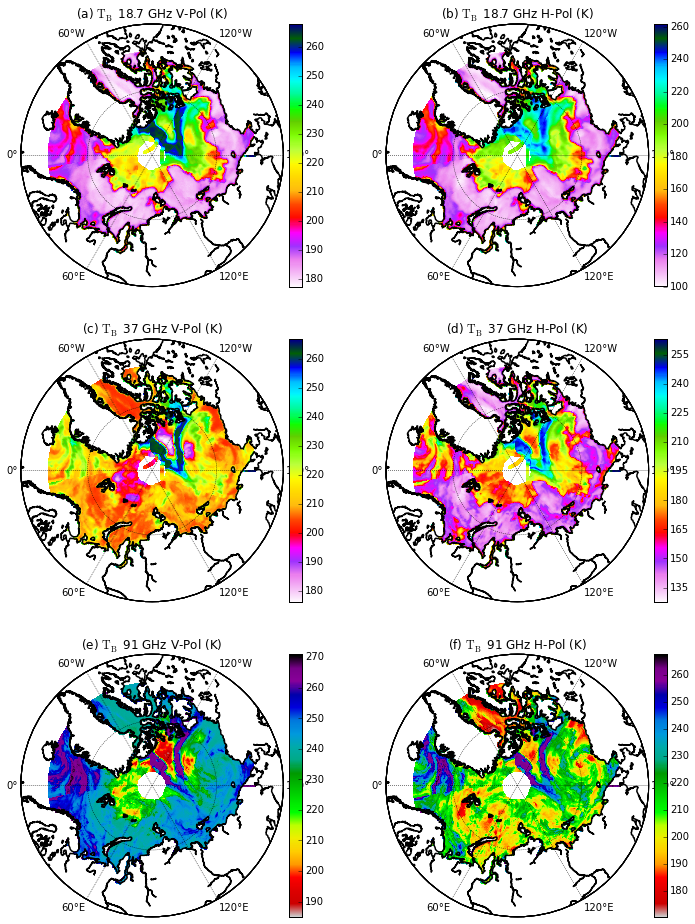

In [19]:
fig = plt.figure(figsize=(12, 16))
ax1=plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1); ax2=plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3=plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1); ax4=plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5=plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1); ax6=plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)

proj1 = map_Arctic(ax1); proj2 = map_Arctic(ax2); proj3 = map_Arctic(ax3)
proj4 = map_Arctic(ax4); proj5 = map_Arctic(ax5); proj6 = map_Arctic(ax6)
x, y = proj1(lon_m, lat_m)

CS = proj1.pcolor(x, y, TB19V_m, cmap=plt.cm.gist_ncar_r); proj1.colorbar(CS)
ax1.set_title('(a) $\mathrm{T_B}$ 18.7 GHz V-Pol (K)', fontsize=12)
CS = proj2.pcolor(x, y, TB19H_m, cmap=plt.cm.gist_ncar_r); proj2.colorbar(CS)
ax2.set_title('(b) $\mathrm{T_B}$ 18.7 GHz H-Pol (K)', fontsize=12)
CS = proj3.pcolor(x, y, TB37V_m, cmap=plt.cm.gist_ncar_r); proj3.colorbar(CS)
ax3.set_title('(c) $\mathrm{T_B}$ 37 GHz V-Pol (K)', fontsize=12)
CS = proj4.pcolor(x, y, TB37H_m, cmap=plt.cm.gist_ncar_r); proj4.colorbar(CS)
ax4.set_title('(d) $\mathrm{T_B}$ 37 GHz H-Pol (K)', fontsize=12)
CS = proj5.pcolor(x, y, TB91V_m, cmap=plt.cm.nipy_spectral_r); proj5.colorbar(CS)
ax5.set_title('(e) $\mathrm{T_B}$ 91 GHz V-Pol (K)', fontsize=12)
CS = proj6.pcolor(x, y, TB91H_m, cmap=plt.cm.nipy_spectral_r); proj6.colorbar(CS)
ax6.set_title('(f) $\mathrm{T_B}$ 91 GHz H-Pol (K)', fontsize=12)

The figure above shows the data that has been used in this study.

## Methods

In this study, polarization ratio is used as an indicator of different sea-ice categories. The polarization ratio is defined as:

$$
PR\left(\nu\right) = \frac{T_B\left(\nu, Vpol\right) - T_B\left(\nu, Hpol\right)}{T_B\left(\nu, Vpol\right) + T_B\left(\nu, Hpol\right)}
$$

2-dimensional histogram is applied here for checking the distribution of observed data points.

K-means clustering is used to distinguish sea-ice types from indicators. K-means clustering aims to partition observations into clusters in which each observation belongs to the cluster with the nearest mean. In this study, it is done by <a href='http://scikit-learn.org/stable/'>**scikit-learn**</a> which is an open source meachine learning tool in Python.

# Sea-ice classification

According to Eppler et. al (1992) and Grenfell et. al (1992), different sea-ice types behave differently under 37 and 19 GHz channels:

* *Open water* has low emissivities on both v-pol. channels. And they are strongly polarized.
* *New ice* or *Grease ice* behaves like *open water* on both channels, since liquid water is trapped in the *new ice* and not completely frozen. 
* Diferent kinds of *Nilas* have slightly higher emissivities than *Open water*, and they are strongly polarized due to the signal of liquid water.
* *First-year ice* has a high and constitude emissivity with less polarization. The emissivity of *First-year ice* is slightly affected by snowpack.
* *Young ice* is on a hard-to-define middle ground between *Nilas* and *First-year ice*. its emissivity depends on the sea state.
* *Multiyear ice* includes pieces of drained, saline and freshwater ice and has more complex radiometric signatures. It has a low emissivity for v-pol. 18.7 GHz channel and a relatively higher emissivity for 37 GHz channel.
* *Pancake ice* is usually smaller than the sensors' spatial resolution and therefore hard to determine. The net brightness of pancakes can be roughly measured by ice thickness. 

The table below is cited from Eppler et. al (1992) shows reference values of emissivity for different ice types:
<img src="_figures/EOSC582_FIG1.jpg" width=800 align="left"/>

In [20]:
Xnum = 150;  Ynum = 150
vpol_37 = TB37V_A.flatten().astype(np.float); 
vpol_19 = TB19V_A.flatten().astype(np.float);
hpol_37 = TB37H_A.flatten().astype(np.float);
hpol_19 = TB19H_A.flatten().astype(np.float);
vpol_91 = TB91V_A.flatten().astype(np.float);

##  37 GHz PR v.s. 18.7 GHz PR

In the classification, *first-year ice* has the lowest polarization ratio for both channels; *open ocean* has the highest; *Nilas* gets the middle. Meanwhile *young ice* is between *Nilas* and *first-year ice* and *New ice* with trapped saline water behaves similarly to *open water*.

*Multiyear ice* has a higher polarization ratio for 18.7 GHz channel. But based on the result below, the absolute difference is not distinct enough for sperating itself by K-means.

In [21]:
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)

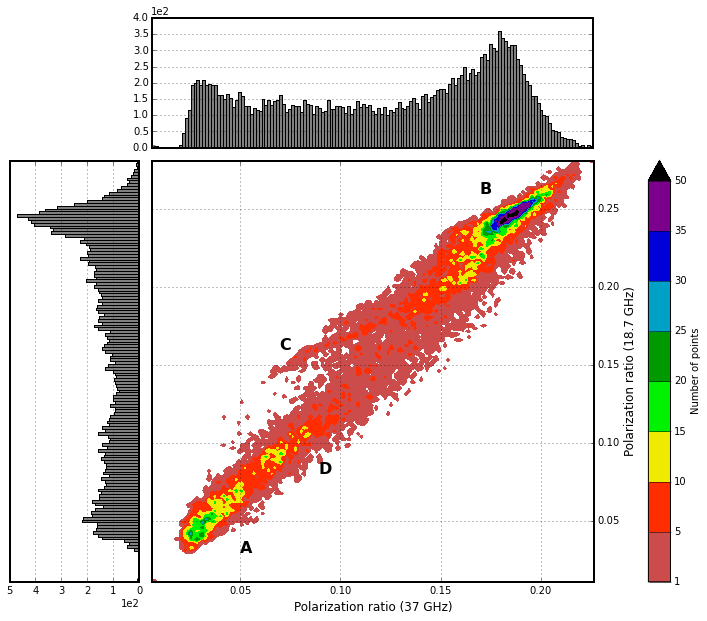

In [22]:
PR37 = po_ratio(vpol_37, hpol_37)
PR19 = po_ratio(vpol_19, hpol_19)
axMain, axHistx, axHisty = hist2dxy(PR37, PR19, Xnum, Ynum, clevs, CMap=CMap)
axMain.text(0.05, 0.03, 'A', fontsize=16, fontweight='bold')
axMain.text(0.17, 0.26, 'B', fontsize=16, fontweight='bold')
axMain.text(0.07, 0.16, 'C', fontsize=16, fontweight='bold')
axMain.text(0.09, 0.08, 'D', fontsize=16, fontweight='bold')
axMain.set_xlabel('Polarization ratio (37 GHz)', fontsize=12)
axMain.set_ylabel('Polarization ratio (18.7 GHz)', fontsize=12)

In the histogram above, data is mainly centered on 2 clusters (A, B) and tailed on C. which means *first-year ice* (A) and *Open ocean* (B) are 2 majorities in this classification. Pattern C indicates the *Multiyear ice* and pattern D is the cluster of *young ice*.

### K-means clustering

Here we set 5 different classes:
* FY thick ice
* Young ice
* Bare Nilas 
* New ice 
* Open water

*Multiyear ice* is not included here since K-means clustering cannot sperate the tailed C region in the histogram above. In this regime, *Multiyear ice* is mainly expressed by classified "Bare Nilas".

In [23]:
n_clusters = 5
TrainData = np.column_stack((PR37, PR19))
hit = ~(np.isnan(TrainData[:, 0]) | np.isnan(TrainData[:, 1]))
TrainData = TrainData[hit]

In [24]:
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(TrainData)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

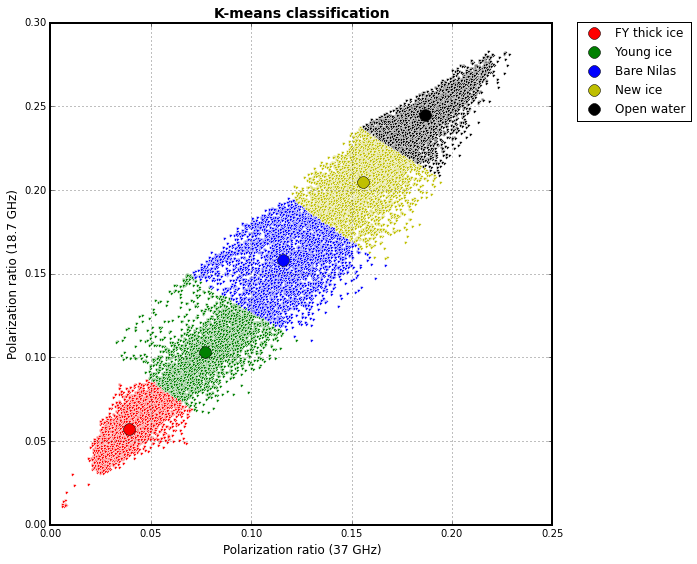

In [25]:
colors = ['r', 'g', 'b', 'y', 'k']
names = ['FY thick ice', 'Young ice', 'Bare Nilas', 'New ice', 'Open water']
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(); [i.set_linewidth(2) for i in ax.spines.itervalues()]
#
kmean_fig(k_means, TrainData, ax, colors, names)
#
ax.grid(); ax.set_title('K-means classification', fontweight='bold', fontsize=14)
ax.legend(numpoints=1, bbox_to_anchor=(1.025, 1.025), loc=2, borderaxespad=1)
ax.set_xlabel('Polarization ratio (37 GHz)', fontsize=12)
ax.set_ylabel('Polarization ratio (18.7 GHz)', fontsize=12)

In [26]:
ICE_Type = back_indexing(k_means, hit, n_clusters)
ICE_Type_masked =np.ma.masked_where(np.isnan(ICE_Type), ICE_Type)

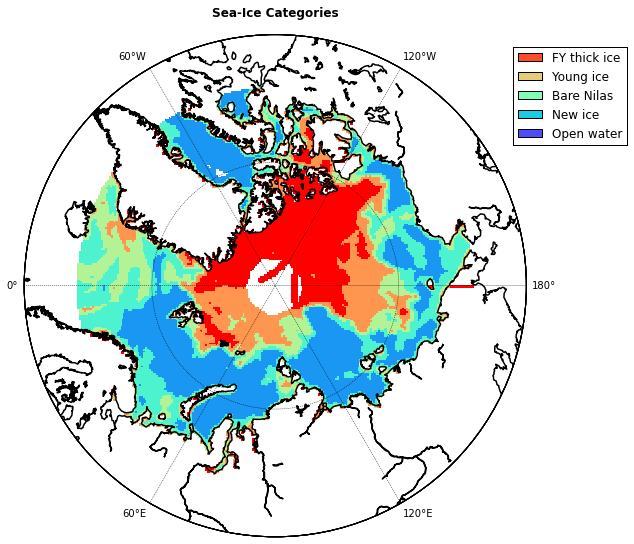

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(); CMap=plt.cm.rainbow_r#plt.cm.PuBuGn_r
plot_icetypes(ICE_Type_masked, ax, n_clusters, names, CMap)
ax.set_title('Sea-Ice Categories', fontweight='bold', y=1.025)

By looking at the result above. 
* *first-year ice* is mainly located at the central Arctic, Canadian Arctic Archipelago (CAA)  and Lincoln sea.
* *Young ice* is located at the northern part of Canada Basin and the northern place between Severnaya Zemlya and Greenland.
* *Bare Nilas* and *New ice* are in the interface between *Young ice* and open ocean.
* Part of the *Bare Nilas* is in the central part of the Arctic ocean is actually *Mutiyear ice*.  

##  37 GHz, V-pol. $\mathsf{T_B}$ v.s. 18.7 GHz, V-pol. $\mathsf{T_B}$

For seperating *Multiyear ice* from other components, an effective way is using 37 and 18.7 GHz vertical polarized brightness temperature.

Two figures below from Eppler et. al (1992) (right) and Grenfell et. al (1992) (left). show a typical classification regime by using V-pol. 18.7 and 37 GHz brightness temperature ($\mathsf{T_B}$). 

<img src="_figures/EOSC582_FIG2.jpg" width=750 align="left"/>

### Histogram

In [28]:
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)

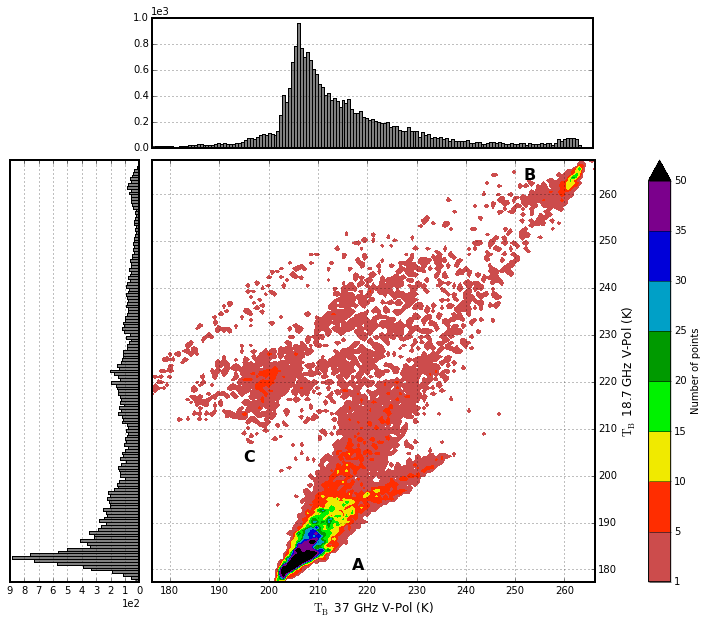

In [29]:
axMain, axHistx, axHisty = hist2dxy(vpol_37, vpol_19, Xnum, Ynum, clevs, CMap=CMap)
axMain.text(217, 180, 'A', fontsize=16, fontweight='bold')
axMain.text(252, 263, 'B', fontsize=16, fontweight='bold')
axMain.text(195, 203, 'C', fontsize=16, fontweight='bold')
axMain.set_xlabel('$\mathrm{T_B}$ 37 GHz V-Pol (K)', fontsize=12)
axMain.set_ylabel('$\mathrm{T_B}$ 18.7 GHz V-Pol (K)', fontsize=12)

From the histogram: A represents *open water*; B is the *FY ice* and C is *mutiyear ice*.

### K-means clustering

In [30]:
n_clusters = 6
TrainData = np.column_stack((vpol_37, vpol_19))
hit = ~(np.isnan(TrainData[:, 0]) | np.isnan(TrainData[:, 1]))
TrainData = TrainData[hit]

In [31]:
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(TrainData)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

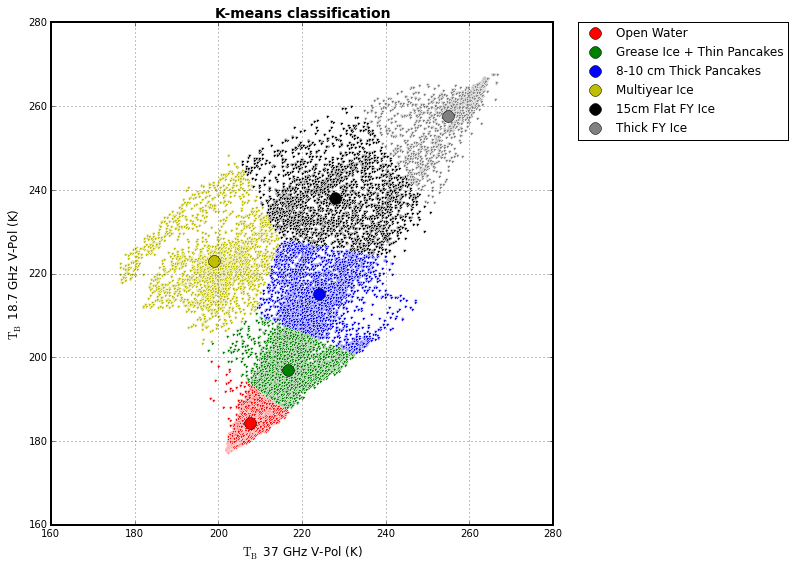

In [32]:
colors = ['r', 'g', 'b', 'y', 'k', 'gray']
names = ['Open Water', 'Grease Ice + Thin Pancakes', '8-10 cm Thick Pancakes', \
         'Multiyear Ice', '15cm Flat FY Ice', 'Thick FY Ice']
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(); [i.set_linewidth(2) for i in ax.spines.itervalues()]
#
kmean_fig(k_means, TrainData, ax, colors, names)
#
ax.grid(); ax.set_title('K-means classification', fontweight='bold', fontsize=14)
ax.legend(numpoints=1, bbox_to_anchor=(1.025, 1.025), loc=2, borderaxespad=1)
ax.set_xlabel('$\mathrm{T_B}$ 37 GHz V-Pol (K)', fontsize=12)
ax.set_ylabel('$\mathrm{T_B}$ 18.7 GHz V-Pol (K)', fontsize=12)

### Plot the classification

In [33]:
ICE_Type = back_indexing(k_means, hit, n_clusters)
ICE_Type_masked =np.ma.masked_where(np.isnan(ICE_Type), ICE_Type)

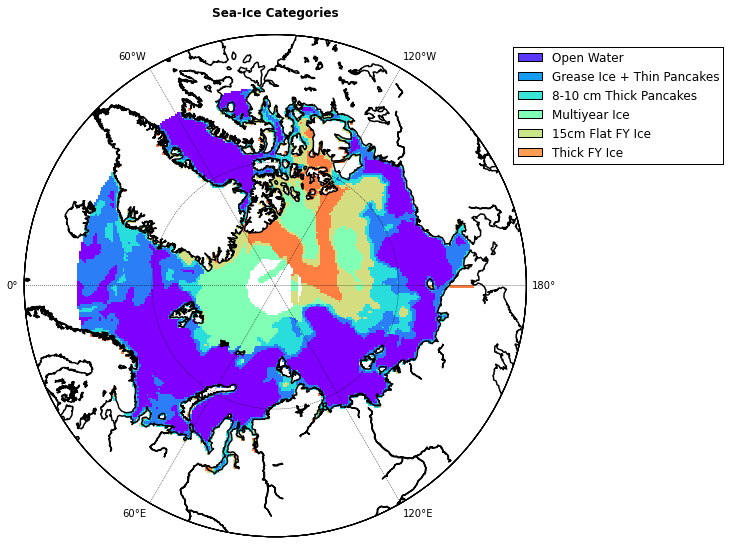

In [34]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(); CMap=plt.cm.rainbow
plot_icetypes(ICE_Type_masked, ax, n_clusters, names, CMap);
ax.set_title('Sea-Ice Categories', fontweight='bold', y=1.025)

# Summary

* In the frame of 37 GHz PR and 18.7 GHz PR, k-means clustering can successfully distinguish all sea-ice types except *multiyear ice*.
* In the frame of 37 GHz, V-pol. $\mathsf{T_B}$ and 18.7 GHz, V-pol. $\mathsf{T_B}$, *Multiyear ice* can be distinguishedby k-means
* K-means clustering in both frames provides a similar range of *open water* and *new ice*/*Grease ice*.
* The frame of 37 GHz PR and 18.7 GHz PR provides a wider range of *first year ice* in CAA and the eastern part of Lincoln sea.

# Reference

[1] Brodzik, M. and R. Armstrong. 2008. Near-Real-Time DMSP SSM/I-SSMIS Pathfinder Daily EASE-Grid Brightness Temperatures. [indicate subset used]. Boulder, Colorado USA: NASA National Snow and Ice Data Center Distributed Active Archive Center. http://dx.doi.org/10.5067/BBQSXI3ERWWY.

[2] Eppler, D. T., Farmer, L. D., Lohanick, A. W., Anderson, M. R., Cavalieri, D. J., Comiso, J., ... & Swift, C. T. (1992). Passive microwave signatures of sea ice. *Microwave Remote Sensing of Sea Ice*, 68, 47-68(Ch.4).

[3] Grenfell, T. C., Cavalieri, D. J., Comiso, J. C., Drinkwater, M. R., Onstott, R. G., Rubinstein, I., ... & Winebrenner, D. P. (1992). Considerations for microwave remote sensing of thin sea ice. *Microwave Remote Sensing of Sea Ice*, 291-301(Ch.14).